,latent_dim,bits,compression,raw_ppl,kv_ppl,ae_ppl,kv_rel,ae_rel,lb_base,lb_comp,lb_rel
0,8,2,64.0,72.7,1150.6,28860.1,15.82,396.75,253.2,44899.9,177.35
1,8,4,32.0,72.7,99.0,4623.1,1.36,63.56,253.2,2113.4,8.35
2,8,8,16.0,72.7,72.5,3171.3,1.00,43.60,253.2,2108.0,8.33
3,8,16,8.0,72.7,72.7,3141.5,1.00,43.19,253.2,2087.4,8.25
4,16,2,32.0,72.7,1142.5,37110.0,15.71,510.24,252.5,9831688.5,38933.48
5,16,4,16.0,72.7,98.8,993.4,1.36,13.66,252.5,1065.5,4.22
6,16,8,8.0,72.7,72.5,772.7,1.00,10.62,252.5,890.9,3.53
7,16,16,4.0,72.7,72.6,790.4,1.00,10.87,252.5,889.1,3.52
8,32,2,16.0,72.7,1150.6,158166.8,15.82,2174.37,253.2,113926.2,450.00
9,32,4,8.0,72.7,99.0,314.1,1.36,4.32,253.2,1002.2,3.96



LaTeX table code:

\begin{table}
\caption{Perplexity degradation and compression ratios for distilGPT‑2 KV‑cache compression.}
\label{tab:compression_results}
\begin{tabular}{rrrrrrrl}
\toprule
latent_dim & bits & compression & kv_rel & ae_rel & lb_base & lb_comp & lb_rel \\
\midrule
8 & 2 & 64.00 & 15.82 & 396.75 & 253.17 & 44899.88 & 177.35 \\
8 & 4 & 32.00 & 1.36 & 63.56 & 253.17 & 2113.41 & 8.35 \\
8 & 8 & 16.00 & 1.00 & 43.60 & 253.17 & 2108.04 & 8.33 \\
8 & 16 & 8.00 & 1.00 & 43.19 & 253.17 & 2087.36 & 8.25 \\
16 & 2 & 32.00 & 15.71 & 510.24 & 252.53 & 9831688.47 & 38933.48 \\
16 & 4 & 16.00 & 1.36 & 13.66 & 252.53 & 1065.49 & 4.22 \\
16 & 8 & 8.00 & 1.00 & 10.62 & 252.53 & 890.91 & 3.53 \\
16 & 16 & 4.00 & 1.00 & 10.87 & 252.53 & 889.12 & 3.52 \\
32 & 2 & 16.00 & 15.82 & 2174.37 & 253.17 & 113926.17 & 450.00 \\
32 & 4 & 8.00 & 1.36 & 4.32 & 253.17 & 1002.23 & 3.96 \\
32 & 8 & 4.00 & 1.00 & 2.57 & 253.17 & 429.95 & 1.70 \\
32 & 16 & 2.00 & 1.00 & 2.36 & 253.17 & 428.66 & 1.69 \\

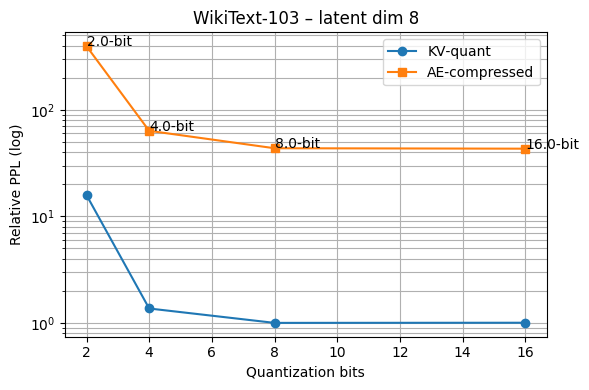

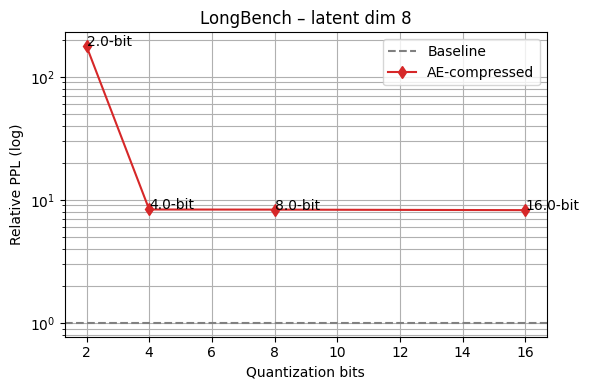

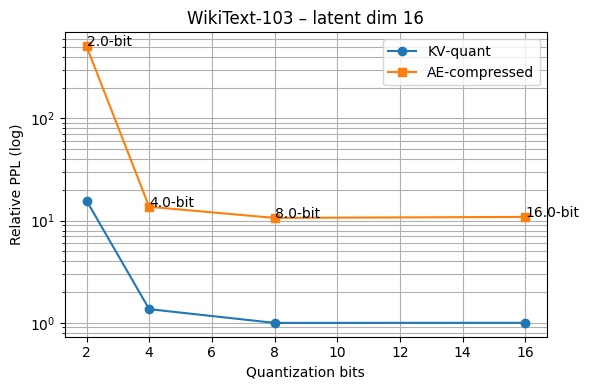

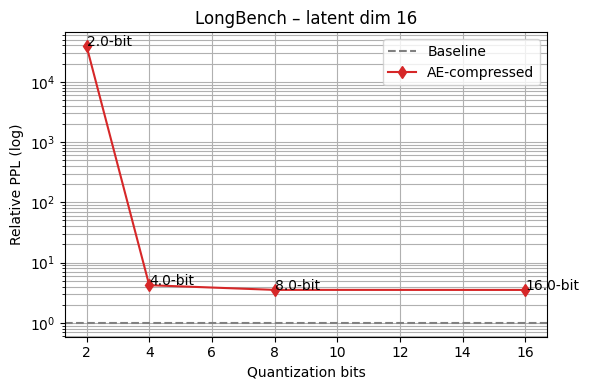

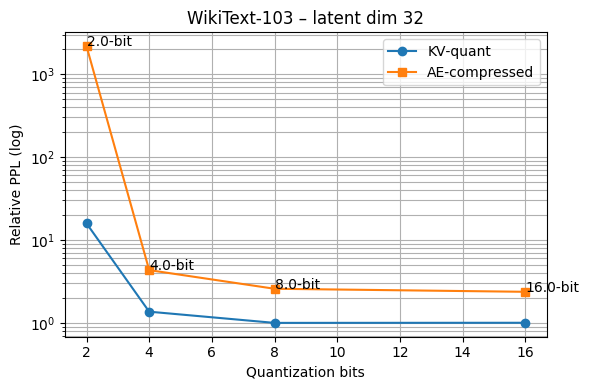

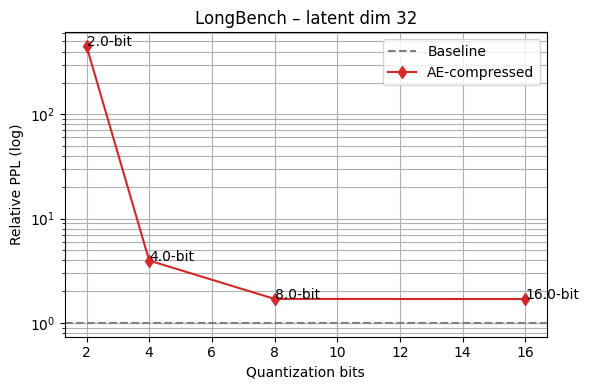

In [1]:
# KV‑cache compression analysis (open‑source only)
# ------------------------------------------------
import json, glob, re, os, math, statistics
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# 1) locate result files in the current directory
files = glob.glob("benchmark_results-latent-*.json")
if not files:
    raise FileNotFoundError("No benchmark_results‑latent‑*.json files in this folder!")

records = []
for path in files:
    latent_dim = int(re.search(r"latent-(\d+)", path).group(1))
    with open(path) as fp:
        res = json.load(fp)

    raw_ppl      = res["raw_baseline_ppl"]
    lb_base_avg  = statistics.mean(res["longbench"]["baseline"].values())

    for bits_str, vals in res["perplexities"].items():
        bits       = int(bits_str)
        kv_ppl     = vals["kv_cache_baseline_ppl"]
        ae_ppl     = vals["ae_compressed_ppl"]
        lb_comp_avg = statistics.mean(res["longbench"]["compressed"][bits_str].values())

        comp_ratio = (64 / latent_dim) * (16 / bits)  # original 64‑d @ 16‑bit → new

        records.append(dict(
            latent_dim = latent_dim,
            bits       = bits,
            compression= comp_ratio,
            raw_ppl    = raw_ppl,
            kv_ppl     = kv_ppl,
            ae_ppl     = ae_ppl,
            kv_rel     = kv_ppl / raw_ppl,
            ae_rel     = ae_ppl / raw_ppl,
            lb_base    = lb_base_avg,
            lb_comp    = lb_comp_avg,
            lb_rel     = lb_comp_avg / lb_base_avg       # ← relative LongBench PPL
        ))

df = (pd.DataFrame(records)
        .sort_values(["latent_dim", "bits"])
        .reset_index(drop=True))

# 2) interactive dataframe
display(df.style.format({
    "compression":"{:.1f}",
    "raw_ppl":"{:.1f}",
    "kv_ppl":"{:.1f}",
    "ae_ppl":"{:.1f}",
    "kv_rel":"{:.2f}",
    "ae_rel":"{:.2f}",
    "lb_base":"{:.1f}",
    "lb_comp":"{:.1f}",
    "lb_rel":"{:.2f}"
}))

# 3) LaTeX table
latex = df[["latent_dim","bits","compression",
            "kv_rel","ae_rel","lb_base","lb_comp","lb_rel"]].to_latex(
            index=False,
            float_format="%.2f",
            caption="Perplexity degradation and compression ratios for distilGPT‑2 KV‑cache compression.",
            label="tab:compression_results",
            column_format="rrrrrrrl")
print("\nLaTeX table code:\n")
print(latex)

# 4) plots for each latent dimension
for latent in sorted(df["latent_dim"].unique()):
    sub = df[df["latent_dim"] == latent]

    # WikiText‑103 relative PPL
    plt.figure(figsize=(6,4))
    plt.plot(sub["bits"], sub["kv_rel"], "o-", label="KV‑quant")
    plt.plot(sub["bits"], sub["ae_rel"], "s-", label="AE‑compressed")
    for _, r in sub.iterrows():
        plt.annotate(f"{r.bits}‑bit", (r.bits, r.ae_rel))
    plt.yscale("log")
    plt.xlabel("Quantization bits")
    plt.ylabel("Relative PPL (log)")
    plt.title(f"WikiText‑103 – latent dim {latent}")
    plt.grid(True, which="both"); plt.legend(); plt.tight_layout(); plt.savefig(f"WikiText‑103 – latent dim {latent}.png")

    # LongBench relative PPL (baseline = 1.0)
    plt.figure(figsize=(6,4))
    plt.axhline(1.0, ls="--", color="gray", label="Baseline")
    plt.plot(sub["bits"], sub["lb_rel"], "d-", color="tab:red", label="AE‑compressed")
    for _, r in sub.iterrows():
        plt.annotate(f"{r.bits}‑bit", (r.bits, r.lb_rel))
    plt.yscale("log")
    plt.xlabel("Quantization bits")
    plt.ylabel("Relative PPL (log)")
    plt.title(f"LongBench – latent dim {latent}")
    plt.grid(True, which="both"); plt.legend(); plt.tight_layout(); plt.savefig(f"LongBench – latent dim {latent}.png")